## Capstone - Milestone 1



In our first step, we scoped out our client's diaper manufacturing process. We identified potential defects in the manufacturing process and what sensors/metrics to monitor. We now have a data set with nearly 591 unlabeled features we will be using to predict defects in the process.

The goals of phase 1 of our project are listed below:
- Join label and feature data
- Impute missing values
- Remove unnecessary columns
- Perform feature engineering
- Check and solve for class imbalance
- Apply feature selection methods to reduce data dimensionality

### Feature Set

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns

data = np.loadtxt('data/secom.data')

# Data here is a numpy array (2 dimensional)
print(data.shape)

(1567, 590)


In [28]:
secom = pd.DataFrame(data)
secom.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


### Labels

In [29]:
#read in labels data

with open('data/secom_labels.data', 'r') as f:
    labels = f.readlines()
    
print(labels[:3])

['-1 "19/07/2008 11:55:00"\n', '-1 "19/07/2008 12:32:00"\n', '1 "19/07/2008 13:17:00"\n']


The data set needs to be cleaned. We'll start by splitting each value in the list using the spaces, then replacing the double quotes with a single quote and stripping any other unnecessary spaces. 

In [30]:
#split by spaces

labels = [label.split(' ') for label in labels]

In [31]:
#replace double quotes and strip extra spaces

labels = [[entry.strip().replace('"', '') for entry in label] for label in labels]

In [32]:
#convert to dataframe

labels = pd.DataFrame(labels, columns = ['target', 'date', 'time'])
labels.head()

,target,date,time
0,-1,19/07/2008,11:55:00
1,-1,19/07/2008,12:32:00
2,1,19/07/2008,13:17:00
3,-1,19/07/2008,14:43:00
4,-1,19/07/2008,15:22:00


We now have a clean data frame of the three columns from the labels data set. Let's join this to the feature set.

In [33]:
#join labels to secom dataset

df = secom.join(labels)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,583,584,585,586,587,588,589,target,date,time
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,19/07/2008,11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,19/07/2008,12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,19/07/2008,13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008,14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,19/07/2008,15:22:00


### Data Cleaning & Feature Engineering

With our data set in one piece, we can now focus on the null values in the data set. Since we are looking to find the most predictive features, we will likely not find signal in columns with an excessive number of missing values. Let's drop columns that have a high percentage of the 1567 observations as null values, as we're highly unlikely to find any of these to be useful in the model.

In [8]:
#dropping columns with over 700 null values
drop_na = list(df.loc[:,df.isna().sum() > 700].columns)
df.drop(drop_na, axis=1, inplace=True)

Next, we'll try to separate categorical from numeric columns. One way to perform this step is to simply classify binary columns as categorical, as we know those are not likely to be numeric.

In [9]:
#initial list
#if unique values in columns are less than 3 append to new list

indices = []

for i in df.columns:
    unique_vals = df[i].unique().shape[0]
    if unique_vals < 3:
        indices.append(i)
print(indices)

[5, 13, 42, 49, 52, 69, 97, 141, 149, 178, 179, 186, 189, 190, 191, 192, 193, 194, 226, 229, 230, 231, 232, 233, 234, 235, 236, 237, 240, 241, 242, 243, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 276, 284, 313, 314, 315, 322, 325, 326, 327, 328, 329, 330, 364, 369, 370, 371, 372, 373, 374, 375, 378, 379, 380, 381, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 414, 422, 449, 450, 451, 458, 461, 462, 463, 464, 465, 466, 481, 498, 501, 502, 503, 504, 505, 506, 507, 508, 509, 512, 513, 514, 515, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 'target']


In [10]:
#convert indices type to category
#classify columns as numeric and categorical

df[indices] = df[indices].astype('category')
cat_cols = df.select_dtypes(['category', 'object']).columns
num_cols = df.select_dtypes(['integer', 'float']).columns

Now having classified binary columns as categorical, we can impute these columns using the mode of each feature. We'll use the mode to impute NAs in the categorical features and the median instead of mean for our numeric columns, as to not be skewed by outliers.

In [11]:
for column in cat_cols:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [12]:
for column in num_cols:
    df[column].fillna(df[column].median(), inplace=True)

Before doing any feature selection, we should make sure to standardize the numeric features in our data. Measurements in our data are likely to have different units and scales, so to account for this, we must transform these features so they are on the same scale.

In [13]:
#initialize standardscaler
#fit numeric columns

from sklearn.preprocessing import StandardScaler

znormalizer = StandardScaler()
znormalizer.fit(df[num_cols])
df[num_cols] = pd.DataFrame(znormalizer.transform(df[num_cols]), columns = num_cols)
df.head(4)

,0,1,2,3,4,5,6,7,8,9,...,583,584,585,586,587,588,589,target,date,time
0,0.224463,0.849523,-0.436430,0.035804,-0.050121,100.0,-0.564354,0.265894,0.509848,1.128455,...,-0.204833,-0.093165,-0.197057,-0.077554,-0.190165,-0.238334,-0.295753,-1,19/07/2008,11:55:00
1,1.107287,-0.383106,1.016977,0.155282,-0.059585,100.0,0.197639,0.321868,0.457021,0.022620,...,0.406734,0.444748,0.385113,-0.960123,0.411970,0.250272,1.156846,-1,19/07/2008,12:32:00
2,-1.114000,0.798901,-0.481447,0.688278,-0.047447,100.0,-0.906768,0.254699,-0.260885,0.327222,...,0.022320,0.014418,0.029888,2.991195,3.627143,3.321511,-0.178955,1,19/07/2008,13:17:00
3,-0.350156,-0.199072,-0.051705,-1.104376,-0.050831,100.0,0.502662,-0.013974,0.343240,-0.765369,...,-0.292200,-0.362121,-0.283360,-0.101845,-0.178804,-0.308135,-0.275049,-1,19/07/2008,14:43:00


### Dealing with Class Imbalance

We need to check the distribution of our target variable before getting to feature selection and modeling. An imbalanced target can lead to biases in our predictions towards the majority class. 

In our case, we are dealing with defects in the manufacturing process. It's likely that the positive cases in such a problem are very low in proportion to the negative ones. Because we are more interested in the model identifying the minority class (when there is a defect in the manufacturing process), we need to pay special attention to the class imbalance problem in this data set. With a very small number of positive cases in the data set, the model we choose will likely find it challenging to predict the minority class in the future because of the lack of historical examples we are feeding it.

Before we apply any methods to solve for class imbalance, let's visualize the target feature to get a better sense of the distribution of positive to negative cases.

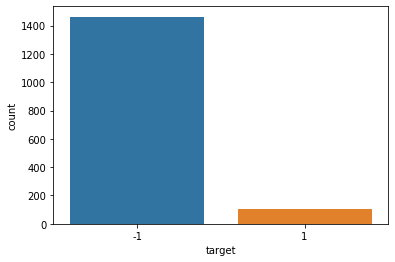

In [14]:
sns.countplot(x = 'target', data = df);

This is clearly a very imbalanced data set with less than 10% of the cases as positive. Before we take care of this, lets first remove more of the features that may not help us, starting with the date and time. These features are not likely to be more predictive than any of our sensor data.

Next, we can remove zero variance features from the model. A higher variance provides the model with more information regarding the relationship between a feature and the target. Columns with a completely uniform set of values are not likely to have any importance to us and can safely be removed ahead of oversampling and feature selection.

In [15]:
#drop date and time

del[df['date']]
del[df['time']]

In [16]:
X = df.drop('target', axis = 1)
Y = df['target']

In [17]:
#import variance threshold package
#default removes zero variance features

from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold()    
X = sel.fit_transform(X)

In [18]:
#convert new array back into data frame

X = pd.DataFrame(sel.fit_transform(X))
X.head()

,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,441
0,0.224463,0.849523,-0.43643,0.0358043,-0.0501211,-0.564354,0.265894,0.509848,1.12845,-0.381577,...,-0.229797,-0.13552,0.118679,-0.204833,-0.093165,-0.197057,-0.0775541,-0.190165,-0.238334,-0.295753
1,1.10729,-0.383106,1.01698,0.155282,-0.0595851,0.197639,0.321868,0.457021,0.0226205,-1.60828,...,-0.263493,-0.460054,0.530183,0.406734,0.444748,0.385113,-0.960123,0.41197,0.250272,1.15685
2,-1.114,0.798901,-0.481447,0.688278,-0.0474466,-0.906768,0.254699,-0.260885,0.327222,0.124169,...,-0.205046,-0.590505,-1.2628,0.0223203,0.0144176,0.0298878,2.99119,3.62714,3.32151,-0.178955
3,-0.350156,-0.199072,-0.051705,-1.10438,-0.0508307,0.502662,-0.0139737,0.34324,-0.765369,-0.370817,...,-0.22495,-0.645708,-0.322218,-0.2922,-0.362121,-0.28336,-0.101845,-0.178804,-0.308135,-0.275049
4,0.242296,0.0873275,1.11723,-0.156616,-0.0470329,-0.115954,0.187531,0.545066,-0.149545,-0.790478,...,-0.230791,-0.454486,-5.90692,26.8672,27.0714,26.9133,-0.101845,-0.178804,-0.308135,-0.275049


Now, having removed over 100 unnecessary features, we can take care of the class imbalance in our data set. We can use SMOTE to over sample the minority class (in this case the defects). SMOTE will balance the number of observations in each class by manufacturing synthetic data using a kmeans clustering algorithm.

SMOTE is a widely used approach to synthesizing new examples in a data set. It's useful to us in this case, because the algorithm can select a minority class at random, find its k nearest minority class neighbor, and then create a synthetic instance by choosing one of the k nearest neighbors at random to form a line segment in the feature space. After we apply SMOTE, we should see a balanced set of positive and negative cases.

In [19]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_smote, Y_smote = smote.fit_resample(X, Y)

df = pd.concat([pd.DataFrame(X_smote), pd.DataFrame(Y_smote, columns = ['target'])], axis = 1)

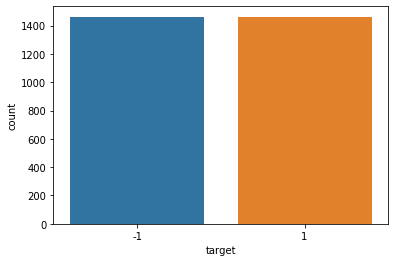

In [20]:
sns.countplot(x = 'target', data = df);

Looks like SMOTE did its job. We can now get into feature selection. 

### Feature Selection

We're going to start by doing a simple mutual information classification to give us a subset of important features to use in our predictive model. The reason for using mutual information is that it provides the important statistical dependencies that exist in our data set in the context of our target variable.

The definition for mutual information is provided below:

*A quantity called mutual information measures the amount of information one can obtain from one random variable given another*

Running a mutual information classification is an efficient way of selecting a set of features that can explain the target variable from a larger data set. After running this, we can use the subset of features chosen by the mutual information classification and run stepwise feature selection to iteratively select a smaller set of predictive features for our model.

In [21]:
#prep for mutual info classification and feature selection
X = df
y = df['target']

In [22]:
#run classification
#convert output to list and show 100 highest mutual information features

from sklearn.feature_selection import mutual_info_classif
import heapq

mi_score = mutual_info_classif(np.array(X), y)

mi = mi_score.tolist()
num = 100

heapq.nlargest(num, enumerate(mi), key = lambda mi: mi[1])

[(442, 0.6933180915103432),
 (294, 0.46870695537474116),
 (436, 0.46299664863045376),
 (192, 0.4596942970684428),
 (148, 0.45752637073357527),
 (107, 0.4535821123996915),
 (110, 0.4534982012291622),
 (94, 0.4531605699911585),
 (128, 0.44667230744107167),
 (139, 0.4463279714785202),
 (229, 0.44407258071961975),
 (291, 0.44364849369650927),
 (295, 0.4417123176595654),
 (201, 0.4416436873067744),
 (293, 0.4398782170889084),
 (284, 0.4358190367813959),
 (149, 0.434040649315383),
 (117, 0.432839840205546),
 (292, 0.4314171330003582),
 (200, 0.4310438512718602),
 (302, 0.42973079543930415),
 (83, 0.42905154060885264),
 (109, 0.4281289103245358),
 (224, 0.427867308722913),
 (115, 0.42410377591798376),
 (102, 0.4230359923723772),
 (286, 0.4220921021508375),
 (440, 0.4219290756162788),
 (6, 0.4200021719235896),
 (290, 0.4194535887965116),
 (220, 0.41848667341226675),
 (95, 0.416638255878798),
 (96, 0.41147109214001154),
 (121, 0.41016067578472293),
 (222, 0.4098428034807773),
 (111, 0.405901080

We now have the 100 features with the highest mutual information. We can use these features to subset our original data set before using a step wise feature selection method called recursive feature elimination.

In [23]:
#use feature names to subset original dataframe

m = heapq.nlargest(num, enumerate(mi), key = lambda mi: mi[1])
X_col = [i[0] for i in m]
X_col = pd.DataFrame(np.array(X_col, ndmin = 2))
X_col = X_col.rename(columns = X_col.iloc[0])

In [24]:
#drop target from X
#subset data frame to selected features by mutual info classification

X_col = X_col.astype('object').columns.drop([442])
X = X[X_col]
X.head()

,294,436,192,148,107,110,94,128,139,229,...,156,145,30,342,397,325,199,250,78,338
0,-1.12549,-0.093165,-1.37371,-0.704959,0.842009,1.18979,0.37018,-0.60092,-0.0858026,0.537776,...,-0.0240888,-0.411725,-0.958019,-0.01624,0.656685,-0.0882377,3.42421,1.58996,-1.04489,0.365113
1,1.12238,0.444748,1.06619,-0.526181,0.842009,0.750364,0.252518,0.572904,-0.139442,0.333164,...,1.28347,-0.231211,-0.213375,1.32406,-0.0108205,-0.132235,0.536435,-0.408111,0.543432,2.35919
2,0.935059,0.0144176,-1.12972,-0.61557,1.04342,1.36556,-1.86539,-0.2879,-0.0321631,0.674184,...,-0.0844808,0.384177,-0.2866,-0.120376,-0.10604,-0.0436085,-0.0783813,0.700382,0.43443,2.58027
3,1.49703,-0.362121,-0.580741,-0.973127,-2.48124,-1.79832,0.37018,-0.91394,-0.139442,0.333164,...,-0.819016,-0.592239,-0.210758,-0.836574,-0.635529,-0.132603,-0.274005,-0.00154785,0.621291,1.6476
4,1.68435,27.0714,-0.153759,0.993435,-0.467148,-0.74369,0.252518,-0.0531354,-0.0679228,0.0262457,...,-0.208074,0.0559701,0.488609,-0.237263,-0.0451341,-0.0719771,0.871789,-1.36023,0.60572,-0.732689


We're going to use recursive feature selection with logistic regression to choose the best features from our subset dataframe, optimizing for accuracy. We will choose 30 of the 100 features that are the most predictive of our target.

In [25]:
# select 30 independent features, removing 1 feature at a time
# import logistic regression
# Recursive Feature Elimination
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE 

estimator = LogisticRegression()

back_selector = RFE(estimator, 30, step = 1)
back_selector = back_selector.fit(X, y)

C:\Users\kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\kumar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\kumar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or sca

C:\Users\kumar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\kumar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\kumar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\kumar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\kumar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\kumar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

We can now output the results and see which features RFE chose for us.

In [26]:
#show features selected by RFE

back_features = pd.DataFrame(back_selector.support_)

sel_back = back_features[0].loc[back_features[0] == True]
sel_back

4     True
7     True
8     True
9     True
10    True
11    True
12    True
17    True
20    True
23    True
25    True
28    True
30    True
31    True
33    True
36    True
48    True
50    True
51    True
63    True
71    True
72    True
74    True
84    True
90    True
91    True
93    True
94    True
95    True
96    True
Name: 0, dtype: bool

### Takeaways

As we are dealing with the complex manufacturing process of diapers and unlabeled sensor data, interpretability is certainly a challenge. With almost 600 independent features, it was important to quickly understand what was *not* going to be helpful in predicting whether there would be defects in the manufacturing process.

In this analysis, we were able to identify over 100 features with uniform values that could safely be removed from the data set. These features were not going to help us explain the target and served as a good first step in bringing down the dimensionality of the data set.

Also, while imputing missing values into the data set, we were able to see that nearly 40 of these features had over 700 (out of the 1567) observations missing. Imputing a uniform median or mode into these features would not help us predict the target. Therefore, these features could also be removed safely.

After scaling the data, we then looked at the distribution of the target variable. This is a business scenario where class imbalance is highly probable. Defects in the manufacturing process of diapers are likely to be rare and this is also a class that the business is more interested in understanding and predicting. We found that less than 10% of the total cases were positive and therefore, had to use SMOTE to oversample the minority class, leaving us with a more balanced target variable ready for us to do feature selection.

In the feature selection process, we found mutual information classification to be a simple method to bring down the feature set to a lower dimensionality, while leaving us with set of features that are likely to be predictive. We could then use the subset of these features in our stepwise feature selection. We set the number of features the model should select at 30 and iteratively went through each independent feature, leaving us with the most important set that we can now use for further analysis and prediction. 